# Synthetic Data Generation Guidelines

Breast Cancer Dataset (~4000 rows) [Breast Cancer via Kaggle](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer). 

This tutorial aims to explore the dangers and usefulness of **synthetic data generation**. Many modern-day machine learning techniques often require "Big Data" (>300,000 rows) in order to provide viable and useful results. While there's a real argument to be made in favor of techniques that don't require large row value data (looking at you, Random Forest), the need for many samples is undeniable in certain cases.  


In the context of smaller datasets, synthetic data generation becomes a powerful tool to address the inherent limitations of sample size. By creating artificial samples, we can simulate a larger dataset to train ML models effectively. However, this approach is not without its challenges and limitations! Improperly generated synthetic data can introduce bias, misrepresent the true distribution of the data, or even overfit the model to patterns that don’t exist in the real world.

This tutorial explores the dangers and advantages of synthetic data generation through practical examples. We’ll begin with a relatively simple and interpretable technique: Bootstrapping with Noise. This method takes the existing data, samples it with replacement, and applies slight perturbations to simulate variability. It’s often a great starting point for creating synthetic datasets, particularly when the goal is to explore how models behave with larger datasets while maintaining the core characteristics of the original data.



In [2]:
import pandas as pd

data = pd.read_csv('../data/Breast_Cancer.csv')

data

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


In [3]:
data.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [4]:
# Very clean data, not a single NA to be found

data.isna().sum()

Age                       0
Race                      0
Marital Status            0
T Stage                   0
N Stage                   0
6th Stage                 0
differentiate             0
Grade                     0
A Stage                   0
Tumor Size                0
Estrogen Status           0
Progesterone Status       0
Regional Node Examined    0
Reginol Node Positive     0
Survival Months           0
Status                    0
dtype: int64

### Early Steps-- Preprocessing
Before we begin augmenting and transforming our data, it's important to get the data into a state that can be manipulated! 
- We'll definitely need to handle those categorical variables... my gut reaction is one-hot encoding, but I'll keep my mind open to other solutions
- No missing values, but always good to include double checking for them in the game plan
- Can't have scale messing with things-- so we'll need to normalize the numerical columns, some standard to equalize the raw values (ex. tumor size vs survival months)


In [5]:
# Preprocess the Data!
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# data = pd.read_csv('Breast_Cancer.csv')

# Label Encoder for ordered categories (ie: `Grade`)
# One-Hot for nominal categories (`Race`, `Marital Status`, etc.)
# Note-- pd.get_dummies is an excellent function that saves a ton of the leg work in One-Hot

cat_cols = ["Race", "Marital Status", "T Stage ", "N Stage", "6th Stage", "differentiate", "Grade", "A Stage", "Estrogen Status", "Progesterone Status", 'Status']

data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True, dtype=int) 

# Not enough samples (19 out of 4024)
data_encoded.drop('differentiate_Undifferentiated', axis='columns', inplace=True)

data_encoded.describe()




,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Other,Race_White,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,6th Stage_IIIC,differentiate_Poorly differentiated,differentiate_Well differentiated,Grade_1,Grade_2,Grade_3,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,...,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962,0.079523,0.848161,0.656809,0.011183,0.152833,...,0.117296,0.276093,0.134940,0.134940,0.584245,0.276093,0.977137,0.933151,0.826541,0.153082
std,8.963134,21.119696,8.099675,5.109331,22.921430,0.270587,0.358909,0.474834,0.105169,0.359871,...,0.321813,0.447119,0.341702,0.341702,0.492913,0.447119,0.149485,0.249791,0.378691,0.360111
min,30.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Method 1: Bootstrapping + Noise
- This method has merit, especially if we're going to use this data to train a NN
- However, this isn't exactly a great idea if we want to ensure a tight model
- We're going to need to enhance this data (ex. ADD NOISE) in order to better "trust it"

In [6]:
from sklearn.utils import resample

bootstrap_samples = resample(
    data_encoded, 
    replace=True,  # Sampling with Replacement here is *key*
    n_samples=int(len(data_encoded) * 10),  # -- I'm using 10 here to create 40,000 new samples as a proof of concept.
    random_state=10
)

bootstrap_samples

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Other,Race_White,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,6th Stage_IIIC,differentiate_Poorly differentiated,differentiate_Well differentiated,Grade_1,Grade_2,Grade_3,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
1289,46,80,26,2,100,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
3197,65,24,10,4,83,0,1,1,0,0,...,0,0,0,0,1,0,1,1,1,0
527,63,21,2,1,54,0,1,1,0,0,...,0,0,0,0,1,0,1,1,1,0
1344,46,35,14,1,83,0,1,1,0,0,...,0,0,0,0,1,0,1,1,1,0
3441,56,30,17,4,79,1,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988,57,60,14,14,18,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,1
651,64,13,24,1,79,0,1,1,0,0,...,0,0,1,1,0,0,1,1,1,0
1640,61,17,19,2,31,1,0,1,0,0,...,0,0,1,1,0,0,1,1,1,0
2892,65,14,8,4,80,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0


Just like that-- we've got 40,000 samples! Problem... it's hard to trust them! 

### Adding Noise 

In [7]:
import numpy as np

def add_noise(data, noise_level=0.01):
    noisy_data = data.copy()
    for col in noisy_data.select_dtypes(include=['float', 'int']):
        noise = np.random.normal(0, noise_level * noisy_data[col].std(), noisy_data[col].shape)
        noisy_data[col] += noise
    return noisy_data

# Apply to bootstrapped data
bootstrap_noisy = add_noise(bootstrap_samples)

bootstrap_noisy.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Other,Race_White,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,6th Stage_IIIC,differentiate_Poorly differentiated,differentiate_Well differentiated,Grade_1,Grade_2,Grade_3,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
count,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,...,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000,40240.000000
mean,54.011383,30.398870,14.298015,4.147081,71.300477,0.079772,0.848224,0.658981,0.011683,0.150456,...,0.117485,0.276216,0.135599,0.135626,0.583758,0.276180,0.977189,0.932214,0.826278,0.150253
std,8.943445,21.098515,8.177584,5.105795,22.846228,0.270971,0.358787,0.474077,0.107446,0.357502,...,0.322016,0.447133,0.342397,0.342405,0.492930,0.447167,0.149309,0.251410,0.378884,0.357342
min,29.794258,0.490087,0.733505,0.789355,0.624388,-0.010467,-0.013909,-0.018289,-0.004651,-0.013682,...,-0.014274,-0.018869,-0.013224,-0.013964,-0.017902,-0.017891,-0.005367,-0.008232,-0.014683,-0.014135
25%,47.067463,16.015110,8.939429,1.021915,56.059742,-0.001637,0.995659,0.003016,-0.000700,-0.001871,...,-0.001832,-0.001713,-0.001911,-0.001895,0.001287,-0.001794,0.998917,0.997857,0.994958,-0.001937
50%,54.061477,24.709933,13.898026,2.020778,72.977491,0.000296,0.999157,0.996675,0.000017,0.000825,...,0.000526,0.002264,0.000665,0.000672,0.994752,0.002232,0.999957,0.999776,0.998995,0.000788
75%,61.155540,37.963596,18.968821,4.976891,89.439815,0.002414,1.001942,1.001500,0.000756,0.004284,...,0.003288,0.994181,0.003831,0.003834,1.000792,0.994279,1.000973,1.001557,1.001953,0.004248
max,69.283624,140.617861,61.144050,46.077842,107.737325,1.010055,1.015902,1.020338,1.003269,1.013616,...,1.012486,1.019025,1.014299,1.011989,1.018791,1.019107,1.006036,1.010309,1.015659,1.013703


As we can see, the sample statistics look a lot better (more aligned with the orignial data)! However, there's a better and more statistically sound method!

## Method 2: Gaussian Mixture Models (GMM)
- Great for generating **realistic**, synthetic samples that mimic the original data distribution -- we tried to do this with `add_noise`, but this is more statistically sound. 


In [8]:
from sklearn.mixture import GaussianMixture

# Step 1: Fit the GMM to our data
n_components = 5
gmm = GaussianMixture(n_components=n_components, random_state=10)
gmm.fit(data_encoded)

# GMM parameters (for learning purposes)
print("Weights of each Gaussian component:", gmm.weights_)


Weights of each Gaussian component: [0.02310159 0.16031248 0.06634624 0.59243652 0.15780318]


In [9]:
# Step 2: Generating synthetic samples
n_samples = 10000
synthetic_data, _ = gmm.sample(n_samples=n_samples) 

# Converting into a df for readability
synthetic_data_df = pd.DataFrame(synthetic_data, columns=data_encoded.columns)


synthetic_data_df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Other,Race_White,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,6th Stage_IIIC,differentiate_Poorly differentiated,differentiate_Well differentiated,Grade_1,Grade_2,Grade_3,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,54.126615,30.321625,14.272888,4.193099,71.534076,0.078844,0.848773,0.654235,0.010391,0.151289,...,0.118947,0.270577,0.136906,0.136906,0.587789,0.270577,0.977683,0.937236,0.829751,0.151858
std,9.034430,21.197732,8.060198,5.190902,23.269177,0.271384,0.359279,0.470695,0.101183,0.358319,...,0.330152,0.445787,0.346899,0.346919,0.495986,0.445802,0.145920,0.251698,0.382303,0.354760
min,16.186092,-12.114089,-19.898992,-15.851277,-29.004704,-1.015127,-1.019124,-1.231872,-1.016594,-1.098789,...,-1.467220,-1.267345,-1.082347,-1.080905,-1.336425,-1.265250,-0.275295,-1.089173,-0.881264,-1.254360
25%,48.128492,17.230670,8.816326,1.279970,56.643388,-0.092746,0.638316,0.346082,-0.000821,-0.089978,...,-0.000730,-0.025870,-0.095323,-0.095342,0.259841,-0.025926,0.998897,0.817909,0.588844,-0.000617
50%,54.159853,25.607695,14.172189,3.047573,72.143678,0.068615,0.862948,0.660430,0.000034,0.150839,...,0.000384,0.260885,0.134105,0.133627,0.586480,0.261107,0.999902,0.997500,0.832826,0.000475
75%,60.170264,36.174116,19.624128,5.589514,87.158848,0.247741,1.083046,0.971703,0.000928,0.396702,...,0.131130,0.560288,0.363026,0.362464,0.918701,0.560117,1.000825,1.060281,1.082890,0.220870
max,87.003410,140.132702,49.406019,34.552721,167.818636,1.480387,2.416666,2.434587,1.733585,1.400247,...,2.368884,2.221753,1.617076,1.616716,2.503481,2.221016,1.927672,2.150485,2.379805,2.029773


Even though this is slightly different than the original `data_encoded.describe()` take note that this is a more realistic idea of what 10,000 samples would turn out to be (minus all the negative generated values in the `min` column, but that's a separate issue!) 

In [10]:
# Step 3: Joining the synthetic data with the orignial

data_augmented = pd.concat([data_encoded, synthetic_data_df], ignore_index=True) 

data_augmented

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Race_Other,Race_White,Marital Status_Married,Marital Status_Separated,Marital Status_Single,...,6th Stage_IIIC,differentiate_Poorly differentiated,differentiate_Well differentiated,Grade_1,Grade_2,Grade_3,A Stage_Regional,Estrogen Status_Positive,Progesterone Status_Positive,Status_Dead
0,68.000000,4.000000,24.000000,1.000000,60.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,50.000000,35.000000,14.000000,5.000000,62.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
2,58.000000,63.000000,14.000000,7.000000,75.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
3,58.000000,18.000000,2.000000,1.000000,84.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,47.000000,41.000000,3.000000,1.000000,50.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14019,48.948954,78.752721,3.156331,0.895715,118.241982,0.373906,0.759485,0.909571,-0.006127,0.409575,...,-0.113471,0.520894,0.512801,0.513115,-0.205098,0.521908,1.107330,1.319778,0.335170,0.617852
14020,50.286918,30.217760,21.638255,-3.156147,122.759755,0.152663,0.563074,-0.061690,-0.090111,0.618096,...,-0.073627,-0.320399,0.510910,0.511842,0.798561,-0.318312,1.010267,1.190664,1.112751,-0.743537
14021,44.840133,66.994762,31.486339,10.105296,107.722719,0.065935,0.854256,-0.371870,0.083536,0.321919,...,0.860568,0.223490,-0.022751,-0.020852,0.815413,0.223185,1.139935,0.993029,1.014356,0.060160
14022,79.264941,88.869705,17.860201,2.025269,85.852397,-0.430649,1.247442,0.363214,-0.036562,0.609882,...,0.017142,0.834162,-0.208729,-0.207723,0.313619,0.837015,0.938089,0.791802,0.105546,-0.120538


## Evaluation!
A good scientist goes back and ensures that the synthetic data is realistic and meets the standards of the originals. We are going to examine synthetic data: 
- Distributions
- Correlations
- and do more direct comparisons (dim reduction via PCA) 
- Statistical significance 

**NOTE:** these tests are *not* necessary! I'm executing them to prove a point and to gain practice!

### Distribution Analysis
- the GMM data should pass this with flying colours, since that's the entire point of the model

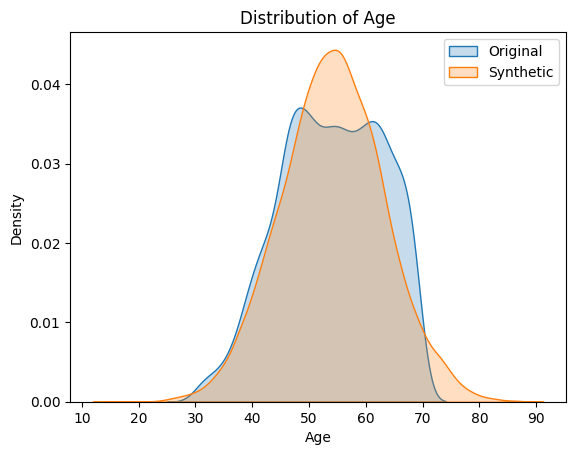

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare distributions of one feature
sns.kdeplot(data_encoded['Age'], label="Original", fill=True)
sns.kdeplot(synthetic_data_df['Age'], label="Synthetic", fill=True)
plt.legend()
plt.title(f"Distribution of {'Age'}")
plt.show()

Looks decent, but perhaps with more `n_components` this dist would be able to better match the original!

### Correlation Analysis

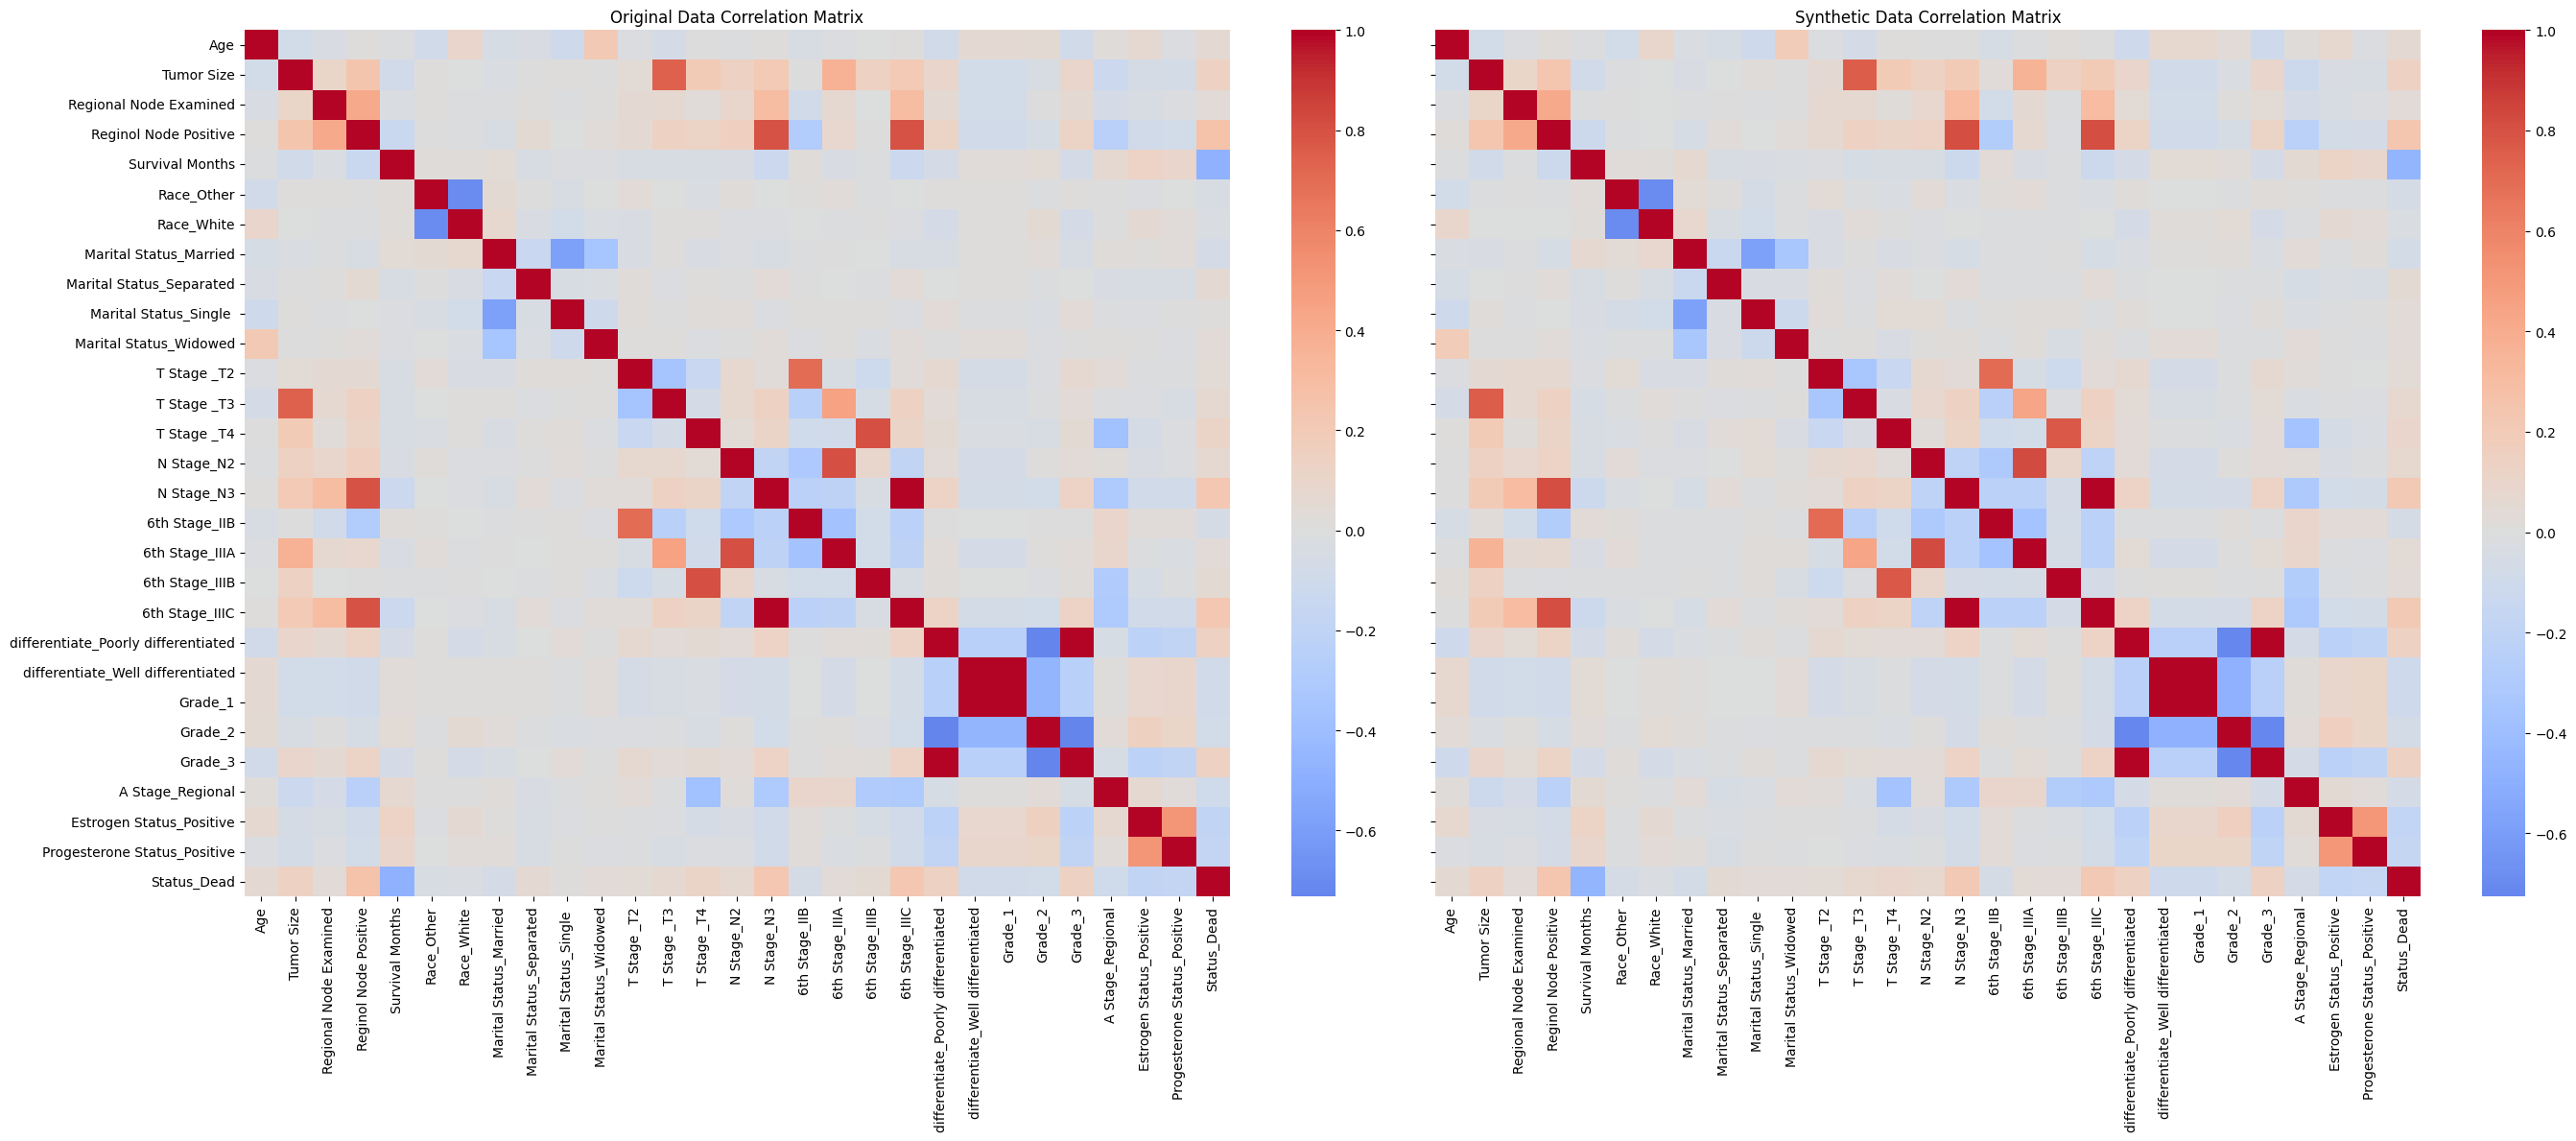

In [12]:
original_corr = data_encoded.corr()
syn_corr = synthetic_data_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(28, 12), sharey=True)

sns.heatmap(original_corr, ax=axes[0], cmap='coolwarm', center=0, annot=False)
axes[0].set_title("Original Data Correlation Matrix")

sns.heatmap(syn_corr, ax=axes[1], cmap="coolwarm", center=0, annot=False)
axes[1].set_title("Synthetic Data Correlation Matrix")

plt.tight_layout()
plt.show()

These look extremely similar! However, keep in mind that the heatmap shows general positivity/negativity for each correlation. There are more precise methods for examining differences

### PCA 
This is the Final Test because if there are any glaring issues, PCA will reveal them
- Reminder: Principle Component Analysis (PCA) is a dimensionality reduction technique, while still preserving the underlying structure
- It's great for image data compression (and much more), but today we're using it for this purpose

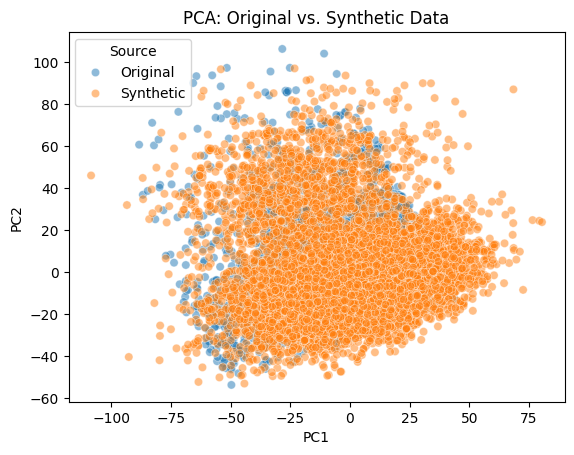

In [13]:
from sklearn.decomposition import PCA

# 2 components makes visualizaton easiest
pca = PCA(n_components=2) 

original_pca = pca.fit_transform(data_encoded) 
syn_pca = pca.fit_transform(synthetic_data_df) 

# Combine PCA-transformed data for visualization
original_pca_df = pd.DataFrame(original_pca, columns=["PC1", "PC2"])
original_pca_df["Source"] = "Original"

syn_pca_df = pd.DataFrame(syn_pca, columns=["PC1", "PC2"])
syn_pca_df["Source"] = "Synthetic"

combo_pca_diff = pd.concat([original_pca_df, syn_pca_df]) 

# Scatter plot of the first two principal components
sns.scatterplot(data=combo_pca_diff, x="PC1", y="PC2", hue="Source", alpha=0.5)
plt.title("PCA: Original vs. Synthetic Data")
plt.show()

### One more for good luck: Statistical Similarity
- Why not! Let's quantify the actual similarity between the original and synthetic dists 


In [14]:
from scipy.stats import ks_2samp

# Compare each feature between original and synthetic data
for column in data_encoded.columns:
    statistic, p_value = ks_2samp(data_encoded[column], synthetic_data_df[column])
    print(f"Feature: {column}, KS Statistic: {statistic:.4f}, p-value: {p_value:.4f}")

Feature: Age, KS Statistic: 0.0625, p-value: 0.0000
Feature: Tumor Size, KS Statistic: 0.0782, p-value: 0.0000
Feature: Regional Node Examined, KS Statistic: 0.0595, p-value: 0.0000
Feature: Reginol Node Positive, KS Statistic: 0.2178, p-value: 0.0000
Feature: Survival Months, KS Statistic: 0.0584, p-value: 0.0000
Feature: Race_Other, KS Statistic: 0.5334, p-value: 0.0000
Feature: Race_White, KS Statistic: 0.5089, p-value: 0.0000
Feature: Marital Status_Married, KS Statistic: 0.4237, p-value: 0.0000
Feature: Marital Status_Separated, KS Statistic: 0.5005, p-value: 0.0000
Feature: Marital Status_Single , KS Statistic: 0.5110, p-value: 0.0000
Feature: Marital Status_Widowed, KS Statistic: 0.4996, p-value: 0.0000
Feature: T Stage _T2, KS Statistic: 0.3441, p-value: 0.0000
Feature: T Stage _T3, KS Statistic: 0.4446, p-value: 0.0000
Feature: T Stage _T4, KS Statistic: 0.5011, p-value: 0.0000
Feature: N Stage_N2, KS Statistic: 0.4920, p-value: 0.0000
Feature: N Stage_N3, KS Statistic: 0.4748

That's a wrap! This data is GOOD TO GO! One might even call this overkill, but I'm trying to prove a point here. Notice how the p-values are all incredibly low.

# Predicting Survival Months

Now that we've sorted out the synthetic data problem, let's continue on to make some predictions regarding this data. 

This is going to be a supervised learning task, with our target variable being `Survival Months`. That means we've got a regression task on our hands! Given data, I want our model to be able to determine the approximate number of months a patient can expect to survive.

In [24]:
# First up, Preprocessing the data!

# Standard 80-20 train-test split

# Furthermore, no need to increase our row values if we're only doing RF! 
# Yes, more data is required for NNs-- but this is an important lesson!

from sklearn.model_selection import train_test_split

# Features X, target y
X = data_encoded.drop(columns='Survival Months')
y = data_encoded['Survival Months']  

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


### Preprocessing and Continued Investigation

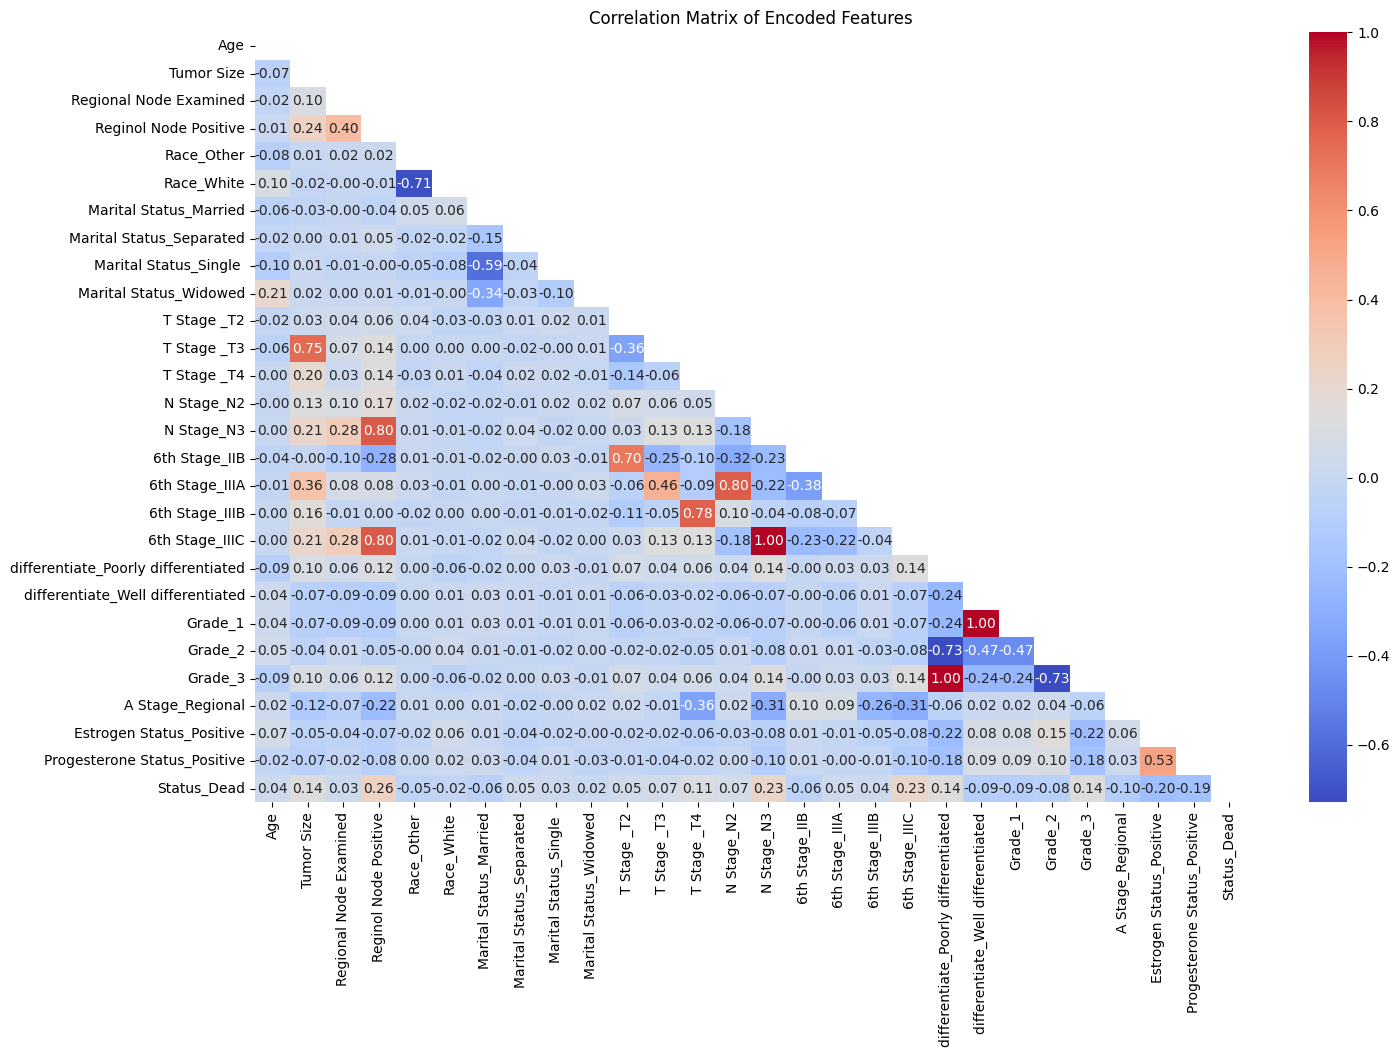

In [34]:
# Correlation Analysis 
# Better to do this on the encoded data, to really paint an all-encompasing picture


correlation_matrix = X_train.corr()

matrix = np.triu(correlation_matrix)

plt.figure(figsize=(16,10))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=matrix)



plt.title("Correlation Matrix of Encoded Features")
plt.show()

NOTE: while this heatmap is great for showing all the encoded features, it's important to remember that some of these interactions we see are not possible within the dataset. For example, one's `Race` cannot be `White` *and* `Other`, so the "correlation" between these terms is simply an artifact of the encodings, not the truth!

Still, we have some interesting observations here! Notably: 
- `T_Stage_T3` and `Tumor Size`
- `N_Stage_N3` and `Reginol Node Positive`
- `6th Stage_IIIC` and `Reginol Node Positive`
- Similarly, T Stage and N Stage appear to be directly responsible or determine 6th Stage
- Similarly, differentiation level apperas to be directly responsible or determine the Grade

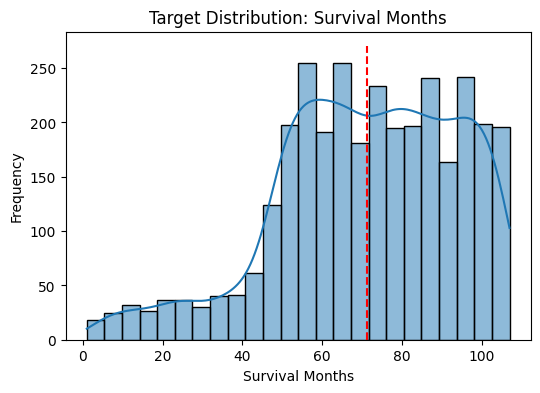

Mean of the target variable is ~70 months survived


In [74]:
# Distribution Analysis

plt.figure(figsize=(6, 4))
sns.histplot(y_train, kde=True)

plt.vlines(y_train.mean(), 0, 270, color='red', linestyles='dashed')

plt.title("Target Distribution: Survival Months")
plt.xlabel("Survival Months")
plt.ylabel("Frequency")

plt.show()

print(f'Mean of the target variable is ~70 months survived')


In [110]:
# Outlier Detection-- IQR and Z-Score

num_cols = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']

Q1 = X_train[num_cols].quantile(0.25)
Q3 = X_train[num_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((X_train[num_cols] < (Q1 - 1.5 * IQR)) | (X_train[num_cols] > (Q3 + 1.5 * IQR))).sum()
print(f"IQR outliers:\n{outliers}\n")

num_mean = X_train[num_cols].mean()
num_std = X_train[num_cols].std()

z_score_outliers = ((X_train[num_cols] < num_mean - 3 * num_std) | (X_train[num_cols] > num_mean + 3 * num_std)).sum()
print(f'Z-Score outliers:\n{z_score_outliers}')

IQR outliers:
Age                         0
Tumor Size                178
Regional Node Examined     56
Reginol Node Positive     272
dtype: int64

Z-Score outliers:
Age                        0
Tumor Size                63
Regional Node Examined    32
Reginol Node Positive     75
dtype: int64


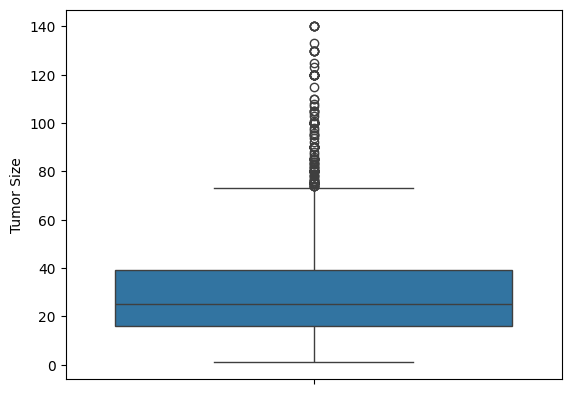

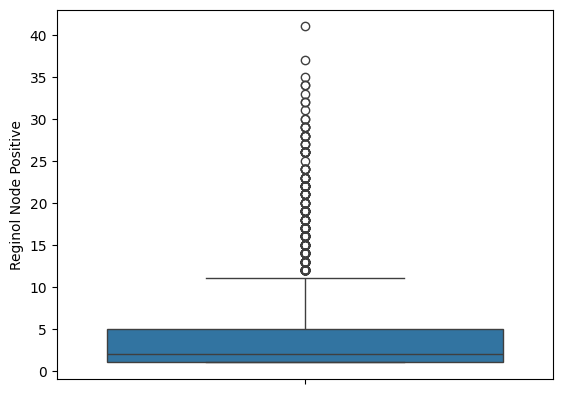

In [111]:
# sns.histplot(X_train['Tumor Size'], kde=True)
sns.boxplot(X_train['Tumor Size'])
plt.show()

# sns.histplot(X_train['Reginol Node Positive'], kde=True)
sns.boxplot(X_train['Reginol Node Positive'])
plt.show()

Since there appears to be a large degree of outliers in `Tumor Size` and `Reginol Node Positive`, I've pulled up some boxplots to examine them more carefully. Dealing with outliers will always be a subjective tasks-- there's no single agreed-upon method. In this case, none of the datapoints stand out too much, but I'll be monitoring these features especially as we move into "Feature Importance" via RF

### Feature Importance with Baseline Random Forest

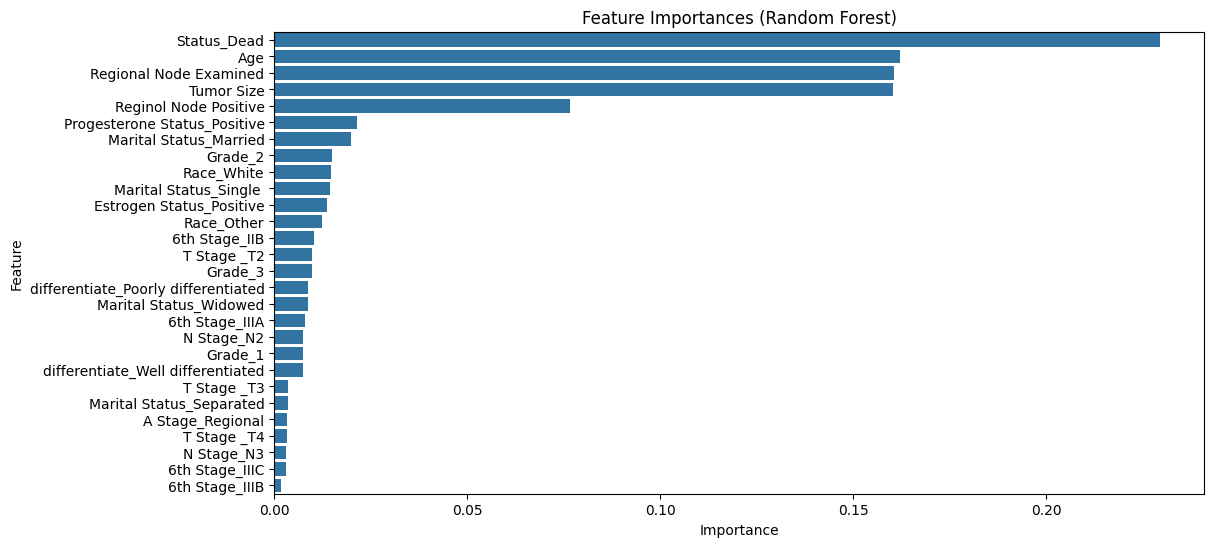

In [116]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=10)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_idx], y=X_train.columns[sorted_idx])

plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.show()


Makes sense, whether or not the patient is alive or dead really plays an impact on how long they will survive. Additionally, `Age`, `Regional Node Examined`, `Tumor Size`, and `Reginol Node Positive` appear to be of the greatest importance.

### Feature Engineering
Now that we've gotten a real hold on our data, we're digging into Feature Regularization, Creation and Reduction techniques.

In [129]:
from sklearn.linear_model import Lasso

# LASSO-- L1 Regularization: encouraging model sparsity! 

lasso = Lasso(alpha=0.01, random_state=10) 
lasso.fit(X_train, y_train)

lasso_importances = np.abs(lasso.coef_)
selected_features = X_train.columns[lasso_importances > 0]
print(f"Selected features based on LASSO:\n{selected_features}\n")

X_train = X_train[selected_features]
X_test = X_test[selected_features]

print(f'LASSO selected {len(selected_features)} features, from 29 originally')

Selected features based on LASSO:
Index(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive',
       'Race_Other', 'Race_White', 'Marital Status_Married',
       'Marital Status_Separated', 'Marital Status_Single ',
       'Marital Status_Widowed', 'T Stage _T2', 'T Stage _T3', 'T Stage _T4',
       'N Stage_N2', 'N Stage_N3', '6th Stage_IIB', '6th Stage_IIIA',
       '6th Stage_IIIB', '6th Stage_IIIC',
       'differentiate_Poorly differentiated',
       'differentiate_Well differentiated', 'Grade_1', 'Grade_2',
       'A Stage_Regional', 'Estrogen Status_Positive',
       'Progesterone Status_Positive', 'Status_Dead'],
      dtype='object')

LASSO selected 27 features, from 29 originally


### Interaction Terms? 
I'm going to skip these for now, we'll return to this section if they are needed!

### Initial Models Selected
- Random Forest (RF) 
- Gradient Boosting Tree
- Good ole Linear Regression

In [124]:
# Working on setting up a more holistic ML approach with imblearn's pipeline!

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=10)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=10)),
    ('Linear Regression', LinearRegression())
]

results = []

# Loop over each model and fit the pipeline
for model_name, model in models:
    # Create the pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Can't forget about standardizing the features!
        ('model', model) 
    ])

    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Eval
    mae = mean_absolute_error(y_test, y_pred)
    mse = root_mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R-squared': r2
    })

for result in results:
    print(f"{result['Model']} - MAE: {result['MAE']}, MSE: {result['MSE']}, RMSE: {result['RMSE']}, R2: {result['R-squared']}\n")




Random Forest - MAE: 17.07808228334812, MSE: 21.160728139205837, RMSE: 4.600079144884992, R2: 0.14589430719484853

Gradient Boosting - MAE: 16.566637760448376, MSE: 20.287857970128915, RMSE: 4.504204476944726, R2: 0.21490394899649823

Linear Regression - MAE: 16.620782140485844, MSE: 20.36488879906795, RMSE: 4.512747367077837, R2: 0.20893077910462088



### Cross Validation (5-Fold CV)